## Introduction

In [1]:
"bla bla bla"

'bla bla bla'

## Development

In [2]:
# Load dataset

import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

churn_od = pd.read_csv('../data/Churn_OD.txt', delimiter = "|", encoding= 'utf-8')
churn_user_profile = pd.read_csv('../data/Churn_UsersProfile.txt', delimiter = "|", encoding= 'utf-8')

print("churn od shape", churn_od.shape, "churn user profile shape", churn_user_profile.shape)

# Load Parish Metadata
parish_metadata = pd.read_excel('../data/freguesias-metadata.xlsx')
parish_metadata = parish_metadata[["distrito", "concelho", "freguesia", "dicofre"]]

# Load Population Density
population_density_censos = pd.read_excel('../data/DistritosConcelhosFreguesias_CAOP2013_Populacao_Censos2011.xls')
population_density_censos.rename(columns={"Freguesia (FR)":"dicofre", "PopRes_2011 (nº)":"População"}, inplace=True)
population_density_censos["dicofre"].str.strip()

# Join parish metadata and this by dicofre
population_density_censos_dicofres = population_density_censos.copy().merge(parish_metadata, on=["dicofre"], how="left")
population_density_censos_dicofres = population_density_censos_dicofres[["Designação DT", "Designação CC", "dicofre", "Designação FR", "População"]]
population_density_censos_dicofres.rename(columns={"Designação DT":"Distrito", "Designação CC":"Concelho", "Designação FR":"Freguesia"}, inplace=True)
population_density_censos_dicofres.head()

# We only want the district, county and parish and the codes, along with the population density
pop_density = population_density_censos_dicofres.copy()

# Rename columns to help in the join
population_density_censos_dicofres_renamed = population_density_censos_dicofres.copy()
population_density_censos_dicofres_renamed.rename(columns = {'dicofre': 'Dicofre_ParishCode_of_Public_Transportation'}, inplace=True)
population_density_censos_dicofres_renamed.head()

# Merge churn_od with pop_density_censos_renamed
churn_od_pop_density = churn_od.merge(
    population_density_censos_dicofres_renamed,
    on=["Dicofre_ParishCode_of_Public_Transportation"],
    how="left"
)

churn od shape (2253, 8) churn user profile shape (544, 7)


In [3]:
churn_od_pop_density.shape

(2253, 12)

In [4]:
pop_density['Population_County'] = pop_density.groupby(['Distrito', 'Concelho'])['População'].transform('sum')

In [5]:
pop_density_concelho = pop_density.groupby(['Distrito', 'Concelho'])['População'].sum().reset_index()

In [7]:
pop_density_concelho

,Distrito,Concelho,População
0,Aveiro,Albergaria-a-Velha,25252
1,Aveiro,Anadia,29150
2,Aveiro,Arouca,22359
3,Aveiro,Aveiro,78450
4,Aveiro,Castelo de Paiva,16733
...,...,...,...
273,Évora,Reguengos de Monsaraz,10828
274,Évora,Vendas Novas,11846
275,Évora,Viana do Alentejo,5743
276,Évora,Vila Viçosa,8319


In [8]:
churn_user_profile = churn_user_profile.merge(pop_density_concelho[['Concelho', 'População']], left_on='County_of_Origin', right_on='Concelho').drop(columns=['Concelho'])

In [9]:
churn_user_profile['Average_BusUsers_per_Day_District_of_Origin'] = churn_user_profile.groupby(["Region_of_Origin", "District_of_Origin", "Period"])['Average_BusUsers_per_Day'].transform('sum')
churn_user_profile['Population_County'] = churn_user_profile.groupby(['County_of_Origin', 'Period'])['População'].transform('sum')
churn_user_profile['Population_District'] = churn_user_profile.groupby(['District_of_Origin', 'Period'])['População'].transform('sum')

## Analysis after data processing

In [10]:
import numpy as np

churn_user_profile_copy = churn_user_profile.copy()

aggr_cols = [
        'Region_of_Origin',
        'District_of_Origin', 
        'County_of_Origin',
        'GenderDescription',
        'AgeClassDescription'
]

def aggregate_relative_change(churn_user_profile_copy, aggr_cols):
    tmp = churn_user_profile_copy.merge(
        churn_user_profile_copy, on=
            aggr_cols, how='left'
    )

    # Keep rows where period_x is different from period_y, and period_x is in 2019
    tmp = tmp[tmp.Period_x != tmp.Period_y]
    tmp = tmp[tmp.Period_x == 'Sep-19 to Feb-20']

    tmp['Relative_Change_AverageBusUsers'] = (tmp['Average_BusUsers_per_Day_y'] - tmp['Average_BusUsers_per_Day_x'])/(tmp['Average_BusUsers_per_Day_x'])
    tmp['Relative_Change_AverageBusUsers_Abs'] = np.abs((tmp['Average_BusUsers_per_Day_y'] - tmp['Average_BusUsers_per_Day_x']))/(tmp['Average_BusUsers_per_Day_x'])
    
    return tmp

In [11]:
churn_user_changes = aggregate_relative_change(churn_user_profile_copy, aggr_cols)

In [12]:
# Example of the data in Vila do Conde, in the two groups that have data

churn_user_changes[
    (churn_user_changes.County_of_Origin == 'Vila do Conde')
]

,Region_of_Origin,District_of_Origin,County_of_Origin,Period_x,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day_x,População_x,Average_BusUsers_per_Day_District_of_Origin_x,Population_County_x,Population_District_x,Period_y,Average_BusUsers_per_Day_y,População_y,Average_BusUsers_per_Day_District_of_Origin_y,Population_County_y,Population_District_y,Relative_Change_AverageBusUsers,Relative_Change_AverageBusUsers_Abs
963,R2 - AM Porto,Porto,Vila do Conde,Sep-19 to Feb-20,Female,25-34,335.380123,79533,222538.173614,238599,12301086,Sep-20 to Jan-21,283.342437,79533,120709.340558,477198,14307187,-0.155160,0.155160
965,R2 - AM Porto,Porto,Vila do Conde,Sep-19 to Feb-20,Female,35-44,144.469939,79533,222538.173614,238599,12301086,Sep-20 to Jan-21,9.758835,79533,120709.340558,477198,14307187,-0.932451,0.932451


### Some baseline statistics on Relative Change in Average Users:

1) Median value is negative: Decrease in users by 36%. The mean value is positive, due to some outliers.

2) Seixal users increased from 37 to 1631, for 15-24 Males!! 
Maybe it is due to the suspension of a boat connection between Seixal and Lisbon?
https://www.publico.pt/2020/10/22/local/noticia/ligacao-fluvial-seixal-lisboa-suspensa-partir-segundafeira-obras-1936350 

The news says the average is 2400 per day, but maybe not in this segment of the population?

3) The highest decrease is in Santa Maria da Feira, 25-34 Females.

4) The lowest absolute change is in Seixal as well, but from the group Male 55-64.

In [13]:
churn_user_changes['Relative_Change_AverageBusUsers'].median(), churn_user_changes['Relative_Change_AverageBusUsers'].mean()

(-0.3636859325701661, 0.3540754887378472)

In [14]:
churn_user_changes.iloc[churn_user_changes['Relative_Change_AverageBusUsers'].argmax()]

Region_of_Origin                                   R1 - AM Lisboa
District_of_Origin                                        Setúbal
County_of_Origin                                           Seixal
Period_x                                         Sep-19 to Feb-20
GenderDescription                                            Male
AgeClassDescription                                         15-24
Average_BusUsers_per_Day_x                                37.6977
População_x                                                158269
Average_BusUsers_per_Day_District_of_Origin_x               41852
Population_County_x                                       1740959
Population_District_x                                     6840006
Period_y                                         Sep-20 to Jan-21
Average_BusUsers_per_Day_y                                1631.34
População_y                                                158269
Average_BusUsers_per_Day_District_of_Origin_y             33726.8
Population

In [15]:
churn_user_changes.iloc[churn_user_changes['Relative_Change_AverageBusUsers'].argmin()]

Region_of_Origin                                        R2 - AM Porto
District_of_Origin                                             Aveiro
County_of_Origin                                 Santa Maria da Feira
Period_x                                             Sep-19 to Feb-20
GenderDescription                                              Female
AgeClassDescription                                             25-34
Average_BusUsers_per_Day_x                                    153.751
População_x                                                    139309
Average_BusUsers_per_Day_District_of_Origin_x                 6041.96
Population_County_x                                            975163
Population_District_x                                         1344965
Period_y                                             Sep-20 to Jan-21
Average_BusUsers_per_Day_y                                    5.51498
População_y                                                    139309
Average_BusUsers_per

In [16]:
churn_user_changes.iloc[churn_user_changes['Relative_Change_AverageBusUsers_Abs'].argmin()]

Region_of_Origin                                   R1 - AM Lisboa
District_of_Origin                                        Setúbal
County_of_Origin                                           Seixal
Period_x                                         Sep-19 to Feb-20
GenderDescription                                            Male
AgeClassDescription                                         55-64
Average_BusUsers_per_Day_x                                1141.76
População_x                                                158269
Average_BusUsers_per_Day_District_of_Origin_x               41852
Population_County_x                                       1740959
Population_District_x                                     6840006
Period_y                                         Sep-20 to Jan-21
Average_BusUsers_per_Day_y                                1118.73
População_y                                                158269
Average_BusUsers_per_Day_District_of_Origin_y             33726.8
Population

In [17]:
(churn_user_changes['Relative_Change_AverageBusUsers'] < 0).mean()

0.799163179916318

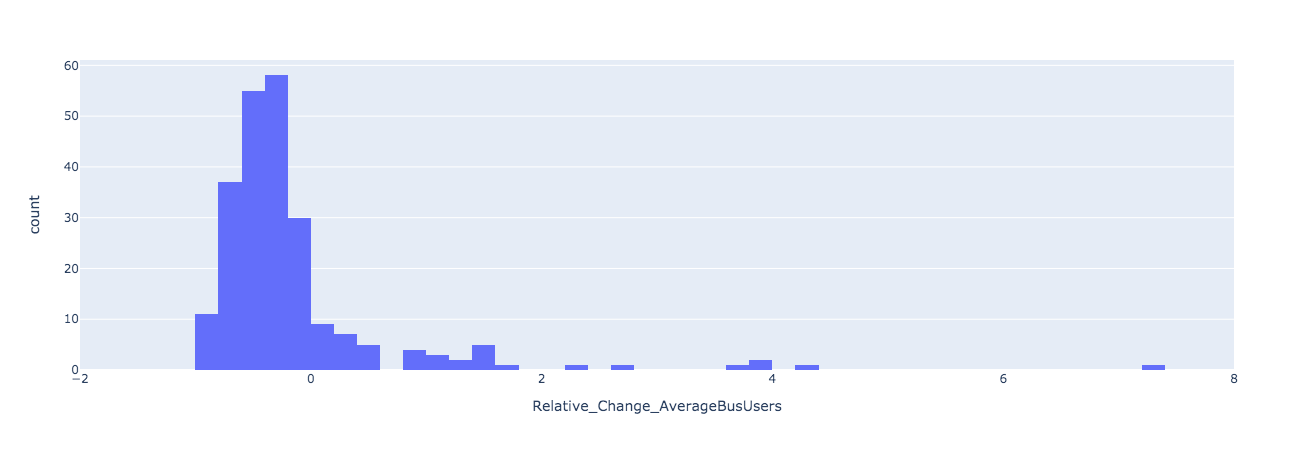

In [19]:
import plotly.express as px
fig = px.histogram(churn_user_changes, x="Relative_Change_AverageBusUsers", nbins=256)
fig.update_xaxes(range=[-2, 8])
fig.show()

In [20]:
churn_od_std_demand = churn_od.groupby(['Region_of_Origin', 'District_of_Origin', 'County_of_Origin'])['Demand_weight'].std().reset_index()
churn_od_std_demand.rename(columns = {'Demand_weight': 'std_demand_weight'}, inplace=True)

churn_user_changes = churn_user_changes.merge(churn_od_std_demand)

In [21]:
X_train = churn_user_changes.copy()

X_train['label'] = X_train['Relative_Change_AverageBusUsers'] < - 0.10 # np.where(X_train['Relative_Change_AverageBusUsers'] > 0, 0, 1)

In [22]:
(X_train['label']).mean()

0.7615062761506276

In [23]:
X_train['Gender_Age'] = X_train['GenderDescription'] + ' ' + X_train['AgeClassDescription']

In [24]:
from xgboost import XGBClassifier

In [25]:
xgb = XGBClassifier()

CAT_COLS = ["Region_of_Origin", 'District_of_Origin', 'GenderDescription', 'AgeClassDescription', 'Gender_Age']
LABEL_COL = ['label']
CONT_COLS = ['std_demand_weight', 'Population_County_y', 'Population_District_y']

df_train = X_train[CAT_COLS + LABEL_COL + CONT_COLS]
df_train = pd.get_dummies(df_train, columns = CAT_COLS)
y_train = df_train[LABEL_COL]
df_train = df_train.drop(columns = LABEL_COL)

xgb.fit(df_train, y_train)

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[22:40:08] WARNING: xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [26]:
import shap

# make sure the SHAP values add up to marginal predictions
pred = xgb.predict(df_train, output_margin=True)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(df_train)

In [27]:
df_train.shape

(239, 29)

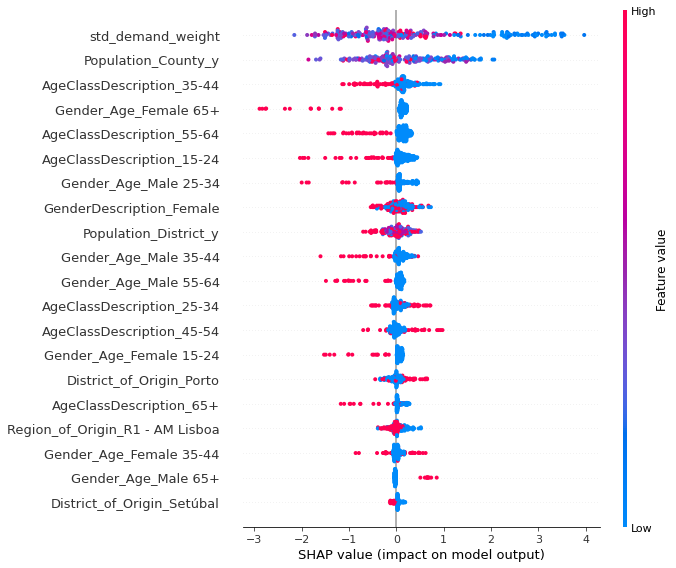

In [34]:
shap.summary_plot(shap_values, df_train)

In [39]:
# Check patterns and detect explainable variables

# Run this command so Jupyter-Lab activates the JS plugin
shap.initjs()

# Perform a force_plot to isualize all the training set predictions
shap.plots.force(base_value=explainer.expected_value, shap_values=shap_values, features=df_train.values, feature_names=df_train.columns)

In [29]:
y_train[df_train['AgeClassDescription_45-54'] == 1].mean()

label    0.875
dtype: float64

In [30]:
y_train.mean()

label    0.761506
dtype: float64

In [31]:
y_train[df_train['GenderDescription_Male'] == 1].mean()

label    0.752137
dtype: float64

## Conclusions

### Scalability and Impact

### Future Work
